In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sippy import *
from sippy import functionset as fset
from sippy import functionsetSIM as fsetSIM
import control.matlab as cnt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%load_ext autoreload

In [2]:
def plot_ARX_model_pred(X_train, X_test, y_train, y_test, time_seq_train,y_pred_train, y_pred_test):
    train_len = len(X_train)
    test_len = len(X_test)

    fig = go.Figure()

    # Add shaded regions for train and test
    fig.add_shape(
        type="rect", x0=0, x1=train_len, y0=min(y_train + y_test), y1=max(y_train + y_test),
        fillcolor="#FFF2DB", opacity=0.3, layer="below", line_width=0, name="Train Region"
    )
    fig.add_shape(
        type="rect", x0=train_len, x1=train_len + test_len, y0=min(y_train + y_test), y1=max(y_train + y_test),
        fillcolor="#A9B5DF", opacity=0.3, layer="below", line_width=0, name="Test Region"
    )

    # Add vertical separator line
    fig.add_shape(
        type="line", x0=train_len, x1=train_len, y0=min(y_train + y_test), y1=max(y_train + y_test),
        line=dict(color="black", width=2, dash="dash")
    )

    # Add step plots
    fig.add_trace(go.Scatter(x=time_seq_train, y=y_train, mode='lines', line=dict(shape='hv', color='blue'), name="Train Actual"))
    fig.add_trace(go.Scatter(x=time_seq_train, y=y_pred_train, mode='lines', line=dict(shape='hv', color='red'), name="Train Prediction"))
    fig.add_trace(go.Scatter(x=list(range(train_len, train_len + test_len)), y=y_test, mode='lines', line=dict(shape='hv', color='green'), name="Test Actual"))
    fig.add_trace(go.Scatter(x=list(range(train_len, train_len + test_len)), y=y_pred_test, mode='lines', line=dict(shape='hv', color='orange'), name="Test Prediction"))
    fig.add_trace(go.Scatter(x=time_seq_train, y=X_train, mode='lines', line=dict(shape='hv', color='black'), name="Train MW", yaxis="y2"))
    fig.add_trace(go.Scatter(x=list(range(train_len, train_len + test_len)), y= X_test, mode='lines', line=dict(shape='hv', color='black'), name="Test MW", yaxis="y2"))

    # Layout settings
    fig.update_layout(
        title="Sys Id. L11 Heat storage energy [MWh] vs 'Heat load forecast [MW]'",
        xaxis_title="Time [15 min]",
        yaxis_title="L11 Heat storage energy Simulation [MWh]",
        yaxis2=dict(
            title="Heat Load [MW]",
            overlaying="y",
            side="right"
        ),
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        template="plotly_white"
    )

    # Show plot
    fig.show()


In [ ]:
# # To merge all csv files to single csv
# folder_path = r"D:\ms\January 2024\Autumn Project\Boiler\aFRR prices\LinHeat Schedules"
# print(Path(folder_path).exists())
# files = list(Path(folder_path).glob("*.csv"))  
# dfs = []
# for file in files:
#     df = pd.read_csv(file, nrows=97)  # Read rows 2 to 97
#     df.columns = df.columns.str.strip()  # Remove leading/trailing spaces in column names
#     dfs.append(df)

# merged_df = pd.concat(dfs, ignore_index=True)  # Ensures rows are stacked correctly

# # Save the merged DataFrame
# merged_df.to_csv("merged_output.csv", index=False)

In [3]:
folder_path = r"D:\ms\January 2024\Thesis\Boiler-Bidding-model\Datasets\LinHeat Schedule January.csv"
january_data = pd.read_csv(folder_path)

In [4]:
# drop the timestamps and only keep the rows with Mwh data
dataset = january_data.dropna(subset=['L11 Heat storage energy [MWh]'])
dataset = dataset.reset_index(drop=True)
# create train and test data set
dataset = dataset[['Heat load forecast [MW]','L11 Heat storage energy [MWh]']]
dataset["Heat load forecast [MW]"] = dataset["Heat load forecast [MW]"].shift(-1)
dataset = dataset.iloc[:-1]

X_train, X_test, y_train, y_test = train_test_split(dataset[['Heat load forecast [MW]']], dataset['L11 Heat storage energy [MWh]'], test_size=0.5, shuffle=False)
# do we need a separate validation set? 


Single input ARX and ARMAX Models

In [10]:
# 2nd order ARX Model
# y lags = 4 (for forecast horizon = 1hr) and u lags = 2
na_ords = [4]
nb_ords = [[2]]
theta = [[0]]
id_ARX = system_identification(y_train, X_train, 'ARX', ARX_orders= [na_ords, nb_ords, theta])
G = id_ARX.G
B = id_ARX.NUMERATOR
A = id_ARX.DENOMINATOR

time_seq_train = np.arange(len(X_train)) #time sequence for the predictor
time_seq_test = np.arange(len(X_test))
time_seq = np.arange(len(dataset))


k = 1 # steps ahead for prediction
y_pred_train = fset.validation(id_ARX, X_train, y_train, Time=np.arange(len(X_train)), k=k)
y_pred_test = fset.validation(id_ARX, X_test, y_test, Time=np.arange(len(X_test)), k=k)
y_pred_train = np.squeeze(y_pred_train)
y_pred_test = np.squeeze(y_pred_test)


from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = mse ** 0.5

print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")


MAE: 1.7606, MSE: 26.3662, RMSE: 5.1348


In [ ]:
# 2nd order ARMAX Model
na_ords = [2]
nb_ords = [[2]]
nc_ords = [2]
theta = [[0]]
id_ARMAX = system_identification(y_train, X_train, 'ARMAX', ARMAX_orders= [na_ords, nb_ords, nc_ords, theta])
G = id_ARMAX.G
H = id_ARMAX.H
B = id_ARMAX.NUMERATOR
A = id_ARMAX.DENOMINATOR
C = id_ARMAX.NUMERATOR_H
D = id_ARMAX.DENOMINATOR_H

time_seq_train = np.arange(len(X_train)) #time sequence for the predictor
time_seq_test = np.arange(len(X_test))
time_seq = np.arange(len(dataset))


k = 1 # steps ahead for prediction
y_pred_train = fset.validation(id_ARMAX, X_train, y_train, Time=np.arange(len(X_train)), k=k)
y_pred_test = fset.validation(id_ARMAX, X_test, y_test, Time=np.arange(len(X_test)), k=k)
y_pred_train = np.squeeze(y_pred_train)
y_pred_test = np.squeeze(y_pred_test)


from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = mse ** 0.5

print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")


In [11]:
plot_ARX_model_pred(X_train, X_test, y_train, y_test, time_seq_train, y_pred_train, y_pred_test)

In [ ]:
C = np.zeros((A.shape[0], A.shape[0])) 
D = np.zeros((A.shape[0], B.shape[0])) 
"""x,y=fsetSIM.SS_lsim_process_form(Identified_system.A, Identified_system.B, Identified_system.C,Identified_system.D, u,Identified_system.x0)"""
x, y_pred = fsetSIM.SS_lsim_process_form(A, B, C, D, x_values)

Use control.matlab.lsim fn to simulate on a new schedule

In [ ]:
# Apply the ARX model to schedule for a day
folder_path = r"D:\ms\January 2024\Thesis\Boiler-Bidding-model\Datasets\LinHeatSchedule_1week_estimatedMWh.csv"
testfile = pd.read_csv(folder_path)
testfile["Heat load forecast [MW]"] = testfile["Heat load forecast [MW]"].shift(-1)
testfile = testfile.iloc[:-1]
x_values = testfile['Heat load forecast [MW]']
x_values = x_values.values
time = np.arange(0, len(x_values), 1)
X0 = [testfile['L11 Heat storage energy [MWh]'][0], testfile['L11 Heat storage energy [MWh]'][1]]


In [ ]:
# X0 = testfile['L11 Heat storage energy [MWh]'][0]
y_pred, Time, Xsim = cnt.lsim(id_ARX.G, x_values, time, X0= X0)

In [ ]:
testfile['predicted MWh'] = y_pred


fig = make_subplots(rows=1, cols=1,shared_xaxes=True,vertical_spacing=0.1,subplot_titles=('Time Series Plot'),specs=[[{'secondary_y': True}]]  )

fig.add_trace(go.Scatter(x=testfile['UTC'], y=testfile['Heat load forecast [MW]'], mode='lines', name='Heat load forecast [MW]'),secondary_y=False)

fig.add_trace(go.Scatter(x=testfile['UTC'], y=testfile['L11 EK plan [MW]'], mode='lines', name='L11 EK plan [MW]'),secondary_y=False)

fig.add_trace(go.Scatter(x=testfile['UTC'], y=testfile['L11 Heat storage energy [MWh]'], mode='lines', name='L11 Heat storage energy [MWh]'),secondary_y=True)

fig.add_trace(go.Scatter(x=testfile['UTC'], y=testfile['predicted MWh'], mode='lines', name='predicted MWh'),secondary_y=True)

fig.update_layout(
    title_text="Time Series of Heat Load Forecast, EK Plan, and Heat Storage Energy",
    xaxis_title="UTC",
    yaxis_title="MW (Heat load forecast & EK plan)",
    yaxis2_title="MWh (Heat storage energy)",
    template="plotly",
)

fig.show()


Model Order Selection

In [ ]:
# Model order selection
n_range = range(1,7)
results = []
for na in n_range:
    na_ords = [na]
    nb_ords = [[na]]
    theta = [[0]]
    id_ARX = system_identification(y_train, X_train, 'ARX', ARX_orders= [na_ords, nb_ords, theta])
    G = id_ARX.G
    num = id_ARX.NUMERATOR
    den = id_ARX.DENOMINATOR
    k = 1 # steps ahead for prediction
    y_pred_train = fset.validation(id_ARX, X_train, y_train, Time=np.arange(len(X_train)), k=k)
    y_pred_test = fset.validation(id_ARX, X_test, y_test, Time=np.arange(len(X_test)), k=k)
    y_pred_train = np.squeeze(y_pred_train)
    y_pred_test = np.squeeze(y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = mse ** 0.5
    results.append({"model": (na, na, 0), "G": G, "num": num, "den": den, "MAE": mae, "MSE": mse, "RMSE": rmse})


error = pd.DataFrame(results)
print(error[['model', 'MAE', 'MSE']])

plt.plot(error['model'].str[0], error['MAE'])

Train ARX model with two inputs Heat load forecast [MW] and L11 EK plan [MW]

In [ ]:
# drop the timestamps and only keep the rows with Mwh data
dataset2 = january_data.dropna(subset=['L11 Heat storage energy [MWh]'])
dataset2 = dataset2.reset_index(drop=True)
# create train and test data set
dataset2 = dataset2[['Heat load forecast [MW]','L11 Heat storage energy [MWh]','L11 EK plan [MW]']]
dataset2["Heat load forecast [MW]"] = dataset2["Heat load forecast [MW]"].shift(-1)
dataset2["L11 EK plan [MW]"] = dataset2["L11 EK plan [MW]"].shift(-1)
dataset2 = dataset2.iloc[:-1]

X_train, X_test, y_train, y_test = train_test_split(dataset2[['Heat load forecast [MW]','L11 EK plan [MW]']], dataset2['L11 Heat storage energy [MWh]'], test_size=0.5, shuffle=False)
# do we need a separate validation set? 

In [ ]:
# 2nd order ARX Model with two inputs
# Define the orders for the ARX model
na_ords = [2] # Order of A(z) (output)
nb_ords = [[2, 1]] # Orders of B(z) for each input (2 inputs, so 2 orders)
# nc_ords = [2]  # Order of C(z) (error model)
theta = [[0, 0]]  # Time delays for each input (2 inputs, so 2 delays)
id_ARX = system_identification(y_train, X_train, 'ARX', ARX_orders= [na_ords, nb_ords, theta])
G = id_ARX.G
num = id_ARX.NUMERATOR
den = id_ARX.DENOMINATOR


time_seq_train = np.arange(len(X_train)) #time sequence for the predictor
time_seq_test = np.arange(len(X_test))
time_seq = np.arange(len(dataset2))


k = 1 # steps ahead for prediction
y_pred_train = fset.validation(id_ARX, X_train, y_train, Time=np.arange(len(X_train)), k=k)
y_pred_test = fset.validation(id_ARX, X_test, y_test, Time=np.arange(len(X_test)), k=k)
y_pred_train = np.squeeze(y_pred_train)
y_pred_test = np.squeeze(y_pred_test)


from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = mse ** 0.5

print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")
%tb

In [ ]:
plot_ARX_model_pred(X_train, X_test, y_train, y_test, time_seq_train, y_pred_train, y_pred_test)

Simulating the ARX/ARMAX model using Regressor form

In [14]:
"""A = id_ARMAX.DENOMINATOR_G  # A(z) coefficients (denominator)
B = id_ARMAX.NUMERATOR_G    # B(z) coefficients (numerator for inputs)
C = id_ARMAX.NUMERATOR_H      # C(z) coefficients (error term)
D = id_ARMAX.DENOMINATOR_H"""
print('G:\n', G)

# print('H: \n', H)
# print('C: ', C)
print('B: ', B)
print('A: ', A , 'is same as D:' ,'for ARMAX model')

A = np.array(A)[0][0]
B = np.array(B)[0][0]
# C = np.array(C)[0][0]

print('B: ', B)
print('A: ', A , 'is same as D:' ,'for ARMAX model')

G:
 
             -0.000915 z^3 + 0.1403 z^2
----------------------------------------------------
z^4 - 1.044 z^3 + 0.009427 z^2 + 0.00399 z + 0.05331

dt = 1.0

B:  [[[-0.0009149747967191079, 0.14029287990754388, 0.0, 0.0]]]
A:  [[[1.0, -1.0441133085318854, 0.00942735129386646, 0.003990069901062543, 0.05331014477123225]]] is same as D: for ARMAX model
B:  [-0.00091497  0.14029288  0.          0.        ]
A:  [ 1.         -1.04411331  0.00942735  0.00399007  0.05331014] is same as D: for ARMAX model


In [21]:
prediction_horizon = 10
forecast_horizon = 6
for count in range(0, forecast_horizon):
    print(count)
    if count <= prediction_horizon:
        print('Using actual y values')
    else:
        print('Using autoregression now')

0
Using actual y values
1
Using actual y values
2
Using actual y values
3
Using actual y values
4
Using actual y values
5
Using actual y values


In [ ]:
a1 = A.squeeze()[1]
a2 = A.squeeze()[2]
b1 = B.squeeze()[0]
b2 = B.squeeze()[1]
c1 = C.squeeze()[1]
c2 = C.squeeze()[2]

In [ ]:
def regressor_model_ARMAX(A, B, C, u, errors, y_init, horizon):
    #theta 
    # theta = np.hstack((A[:, 1:], B, C[:, 1:]))
    theta = np.hstack((A, B, C))
    theta = np.transpose(theta)
    y = np.zeros(horizon)
    psi_k = np.zeros((horizon, 6))
    # Set initial u and y
    y[0] = y_init
    y[1] = y_init
    # u[0] = u_init
    # u[1] = u_init
    for t in range(2, horizon):
        psi_k[t] = np.array([[-y[t-1], -y[t-2], u[t-1], u[t-2], errors[t-1], errors[t-2]]])

        y[t] = psi_k[t] @ theta
    return y

In [ ]:
np.hstack((A[1:], B[:-2]))

In [10]:
def regressor_model_ARX(A, B, y_actual, u, horizon):
    # model has 4 y lags and 2 u lags
    theta = np.hstack((A, B))
    theta = np.transpose(theta)
    y_hat = np.zeros(horizon)
    y_pred = np.zeros(horizon)
    psi_k = np.zeros((horizon, 6)) # 4 + 2 lags
    # Set initial u and y
    for i in range(0,4):
        y_hat[i] = y_actual[i]
        y_pred[i] = y_actual[i]

    for j in range(4, horizon, 4):
        y_hat[j-4:j] = y_actual[j-4:j]
        for k in range(0, 4):
            t = j+k
            psi_k[t] = np.array([[-y_hat[t-1], -y_hat[t-2], -y_hat[t-3], -y_hat[t-4], u[t], u[t-1]]])
            y_hat[t] = psi_k[t] @ theta
        if j <= 92:
            y_pred[j:j+4] = y_hat[j:j+4]

        # y[k] = -A[1] * y[k-1] - A[2] * y[k-2] + B[0] * u[k-1] + B[1] * u[k-2]
    return y_pred, y_hat

In [6]:
# load A and B
B = np.array([-0.00091497,  0.14029288])
A = np.array([-1.04411331, 0.00942735,  0.00399007,  0.05331014])

In [11]:
folder_path = r"D:\ms\January 2024\Thesis\Boiler-Bidding-model\Datasets\boiler-12025022508_00_17_LHP_2_PHLIT_export.csv"
testfile = pd.read_csv(folder_path)
testfile["Heat load forecast [MW]"] = testfile["Heat load forecast [MW]"] #.shift(-2)
# testfile = testfile.iloc[:-2]
u = testfile['Heat load forecast [MW]'].values
y = testfile['L11 Heat storage energy [MWh]'].values
y_pred, y_hat = regressor_model_ARX(A, B, y, u, horizon = 96)
# y_pred = regressor_model_ARMAX(A, B, C, u, e, y_init, horizon = len(u))

In [ ]:
from model_simulator import ARXSimulator

simulator = ARXSimulator(A[1:], B[:-2], 24, 30)
y_pred = simulator.simulate(y, u)

In [12]:
# testfile['predicted MWh'] = y_pred
y_pred_padded = np.zeros(len(testfile))  
y_pred_padded[:len(y_pred)] = y_pred
testfile['predicted MWh'] = y_pred_padded

fig = make_subplots(rows=1, cols=1,shared_xaxes=True,vertical_spacing=0.1,subplot_titles=('Time Series Plot'),specs=[[{'secondary_y': True}]]  )

fig.add_trace(go.Scatter(x=testfile['UTC'], y=u, mode='lines', name='Heat load forecast [MW]'),secondary_y=False)

fig.add_trace(go.Scatter(x=testfile['UTC'], y=testfile['L11 EK plan [MW]'], mode='lines', name='L11 EK plan [MW]'),secondary_y=False)

fig.add_trace(go.Scatter(x=testfile['UTC'], y=testfile['L11 Heat storage energy [MWh]'], mode='lines', name='L11 Heat storage energy [MWh]'),secondary_y=True)

fig.add_trace(go.Scatter(x=testfile['UTC'], y=testfile['predicted MWh'], mode='lines', name='predicted MWh'),secondary_y=True)

fig.update_layout(
    title_text="Time Series of Heat Load Forecast, EK Plan, and Heat Storage Energy",
    xaxis_title="UTC",
    yaxis_title="MW (Heat load forecast & EK plan)",
    yaxis2_title="MWh (Heat storage energy)",
    template="plotly",
)

fig.show()

In [ ]:
u_test = u[:26]

y_test = np.zeros(len(u_test))
y_test[0] = testfile['L11 Heat storage energy [MWh]'][0]
y_test[1] = testfile['L11 Heat storage energy [MWh]'][1]
for k in range(2, len(y_test)):
    y_test[k] = (-A[1] * y_test[k-1] - A[2] * y_test[k-2] + B[0] * u_test[k-1] + B[1] * u_test[k-2])
print(testfile['L11 Heat storage energy [MWh]'][:26])

In [ ]:
plt.figure()
plt.plot(testfile['L11 Heat storage energy [MWh]'][:26], label="Actual Data")
plt.plot(y_test, label="Predicted Data")
plt.legend()
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_linreg = pd.Series(lin_reg.predict(X_test), name = 'Y_predicted')

ValueError: x and y must have same first dimension, but have shapes (15,) and (25,)

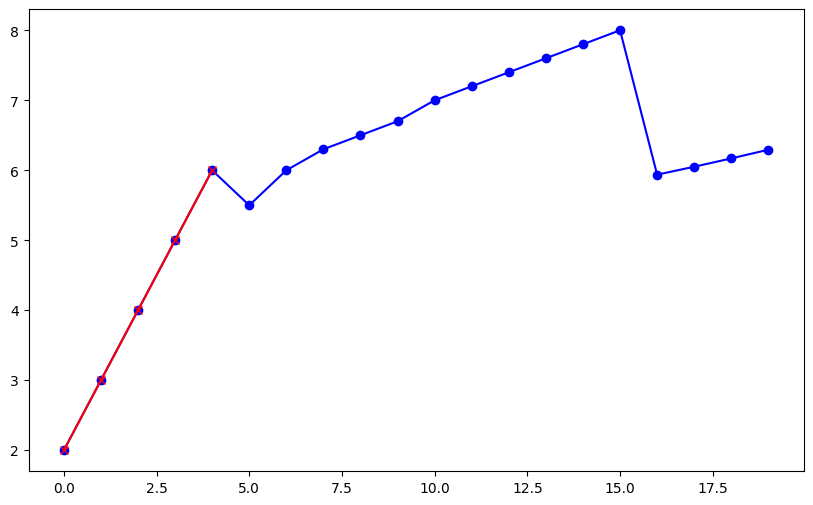

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming AR(4) model with example coefficients
alpha = np.array([0.5, 0.3, 0.1, 0.1])  # AR coefficients
n_steps = 20  # Forecasting up to index 20

# Initial known values (y0 to y4)
y_values = np.array([2, 3, 4, 5, 6])
lags = 4
# Actual values from y5 to y20 (known values)
y_actual = np.array([2, 3, 4, 5, 6, 5.5, 6.0, 6.3, 6.5, 6.7, 7.0, 7.2, 7.4, 7.6, 7.8, 
                     8.0, 8.1, 8.3, 8.5, 8.7, 8.9, 9.1, 9.2, 9.3, 9.4])

# Recursive function to simulate the forecasting with actuals revealed
def recursive_forecast_with_actuals(alpha, y_values, y_actual, n_steps):
    for i in range(len(y_values), n_steps):  # Continue from the last known value
        if i < len(y_values):  # No autoregression in the first 5 steps (use actual known values)
            continue
        
        if (i - lags) > lags:  # Use actual values when they are available
            y_values[i-lags] = y_actual[i-lags]  # Correct the forecast with the actual value

        # Use autoregression for forecasting the next value
        y_new = np.dot(alpha, y_values[i-4:i][::-1])  # Reverse the past values for AR(4)
        y_values = np.append(y_values, y_new)  # Add the forecasted value to the array
        
            
    return y_values

# Run the forecast and reveal actual values
y_forecast_corrected = recursive_forecast_with_actuals(alpha, y_values, y_actual, n_steps)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(n_steps), y_forecast_corrected, label="Forecasted and Corrected Values", marker='o', color='b')
plt.plot(range(5), y_values[:5], label="Known Values (y0 to y4)", marker='x', color='r')  # Known values up to y4
plt.plot(range(5, n_steps), y_actual, label="Actual Values Revealed (y5 to y20)", marker='o', linestyle='--', color='g')
plt.xl
